In [24]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import os
from pathlib import Path
import pandas as pd
import pydicom
from tqdm import tqdm
from scipy import stats
from skimage import transform
from skimage.exposure import rescale_intensity
import glob

from PIL import Image
rng = np.random.RandomState(42)
covid_datasets_dir = Path('covid-datasets')
print('Loaded!')

Loaded!


Total COVID-19 Images: 526
Total COVID-19 X-Rays: 446
Total Unique Patient COVID-19 X-Rays: 259
Total Unique Patient COVID-19 PA, AP, or AP Supine X-Rays: 259


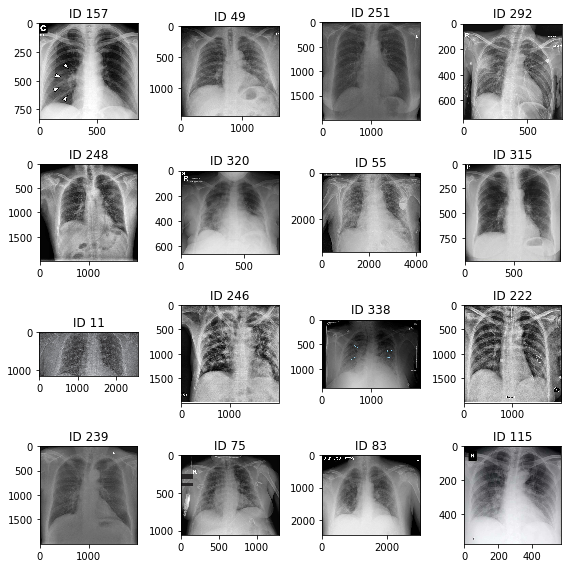

In [77]:
##### filtering out unimportant data
cohen_covid_md = pd.read_csv(str(Path('covid-datasets/covid-chestxray-dataset/metadata.csv')))
# Removes all non-covid data from dataframe
cohen_covid_md = cohen_covid_md[(cohen_covid_md['finding'] == 'COVID-19')]
print(f'Total COVID-19 Images: {cohen_covid_md.shape[0]}')
# Removes all non-X-Ray data from dataframe
cohen_covid_md = cohen_covid_md[(cohen_covid_md['modality'] == 'X-ray')]
print(f'Total COVID-19 X-Rays: {cohen_covid_md.shape[0]}')
# Drops all duplicated patient X-rays except for the first X-ray (earliest offset)
cohen_covid_md = cohen_covid_md.drop_duplicates('patientid', keep='first')
print(f'Total Unique Patient COVID-19 X-Rays: {cohen_covid_md.shape[0]}')
# Removes all Lateral X-rays (keeps only PA or AP images)
cohen_covid_md = cohen_covid_md[cohen_covid_md['view'].isin(['PA', 'AP', 'AP Supine'])]
print(f'Total Unique Patient COVID-19 PA, AP, or AP Supine X-Rays: {cohen_covid_md.shape[0]}')
cohen_image_dir = covid_datasets_dir / 'covid-chestxray-dataset' / 'images'
# gets a list of all .png and .jpg images in cohen dataset
# cohen_image_paths = sorted(list(cohen_image_paths.glob('**/*.png')) + list(cohen_image_paths.glob('**/*.jpg')))
sqrt_n_samples = 4
fig, axes = plt.subplots(nrows=sqrt_n_samples, ncols=sqrt_n_samples, figsize=(8,8))
xray_samples = cohen_covid_md.sample(n=sqrt_n_samples**2, random_state=rng, axis=0)
for ax, xray_sample in zip(axes.ravel(), xray_samples.iterrows()):
    xray_sample = xray_sample[1]
    image = plt.imread(str(cohen_image_dir / xray_sample['filename']))
    ax.imshow(image, cmap='gray')
    ax.set_title(f"ID {xray_sample['patientid']}")
plt.tight_layout()
plt.show()

# Image Preprocessing

1. Interpolation to same size -- (224, 224)
2. Percentile cropping  -- image intensity cropped to 1st and 95th percentile
3. Intensity normalisation -- stretched/compressed to \[0, 1\]

...Interpretability Techniques for COVID-19 paper


-- OR --

(not explored)

1. Histogram equalization
2. Lung segmentation (extracting the lungs from the image and only using the extraction)

... Unveiling COVID-19 paper


In [8]:
def resize_clip_and_normalize_image(image):
    """
    * resizes image to be image_sizeximage_size pixels using bicubic interpolation, 
    **********NOTE: aspect ratio is no longer kept*********
    * clips resized image to the 1st and 95th percentiles of the resized image
    * normalizes the clipped image to range of [0,1]
    """
    n_channels = 1
    desired_image_size = 224
    height = desired_image_size
    width = desired_image_size
    # sets image and height to have size image_size while keeping proper aspect ratio
#     height = image.shape[0]
#     width = image.shape[1]

#     ratio = height / width

#     if height >= width:
#         height = image_size
#         width = int(image_size / ratio)  # since inverted since ratio should be min / max

#     else:
#         width = image_size
#         height = int(image_size * ratio)

    resized_image = transform.resize(image, (height, width, n_channels), order=3,
                 mode='constant', cval=0)  # order=3 is bi-cubic interpolation

#     if height >= width:
#         padding = np.zeros((image_size, height-width, n_channels))
#         resized_image = np.concatenate((resized_image, padding), axis=1)
#     else:
#         padding = np.zeros((width-height, image_size, n_channels))
#         resized_image = np.concatenate((resized_image, padding), axis=0)

    # first clips image to (1, 95)th percentiles of the image, and then normalizes it to [0,1]
    p1, p95 = np.percentile(np.ravel(resized_image), (1, 95))
    resized_image = rescale_intensity(resized_image,
                                               in_range=(p1, p95),
                                              out_range=(0, 1))
    resized_image = resized_image.reshape(desired_image_size, desired_image_size, 1)
    resized_image = np.concatenate((resized_image, resized_image, resized_image), axis=-1)
    return resized_image

OG shape: (958, 1015, 3),           Processed shape: (224, 224, 3)
OG shape: (956, 1280, 3),           Processed shape: (224, 224, 3)
OG shape: (1570, 1695, 3),           Processed shape: (224, 224, 3)


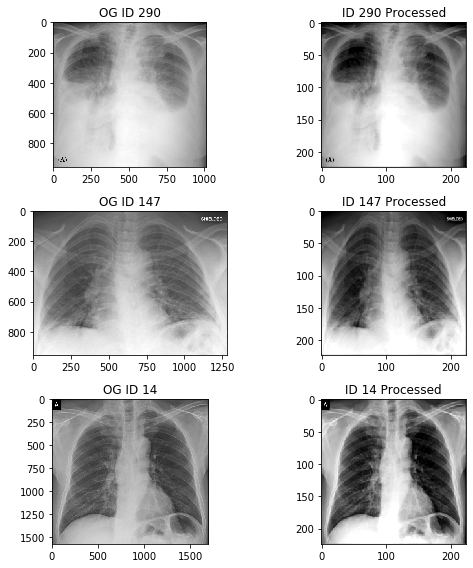

In [76]:
# showing the output of the image processing.
n_samples = 3
fig, axes = plt.subplots(nrows=n_samples, ncols=2, figsize=(8,8))
xray_samples = cohen_covid_md.sample(n=n_samples, random_state=rng, axis=0)
for ax_row, xray_sample in zip(axes, xray_samples.iterrows()):
    xray_sample = xray_sample[1]
    image = plt.imread(str(cohen_image_dir / xray_sample['filename']))
    ax_row[0].imshow(image, cmap='gray')
    ax_row[0].set_title(f"OG ID {xray_sample['patientid']}")
    processed_image = resize_clip_and_normalize_image(image)
    print(f'OG shape: {image.shape}, \
          Processed shape: {processed_image.shape}')
    ax_row[1].imshow(processed_image, cmap='gray')
    ax_row[1].set_title(f"ID {xray_sample['patientid']} Processed")
plt.tight_layout()
plt.show()

# Saving all processed images to the model-images folder

In [19]:
model_datasets_dir = Path('extended-model-datasets')

In [94]:
# Making sure all files in the model-images folder are only images in our cohen_covid_md
covid_filenames = cohen_covid_md['filename'].copy().values
covid_filenames = [str(cohen_image_dir / file) for file in covid_filenames]
# covid_filenames = apply(lambda x: str(cohen_image_dir / x))
print(f'Number of covid_images: {len(covid_images)}')

Number of covid_images: 259


In [98]:
covid_dir = model_datasets_dir / 'covid-images'
for file in tqdm(covid_filenames):
    image = np.asarray(Image.open(file))
    processed_image = resize_clip_and_normalize_image(image)
    processed_image = Image.fromarray(np.clip((processed_image * 255).astype(np.uint8), 0, 255))
    filename = file
    processed_image.save(covid_dir / os.path.basename(file))    

100%|███████████████████████████████████████████████████████████████████████████████████████████| 259/259 [02:24<00:00,  1.79it/s]


(224, 224, 3)


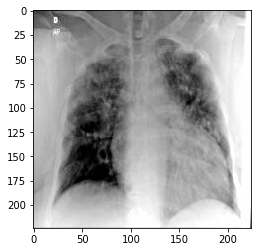

(224, 224, 3)


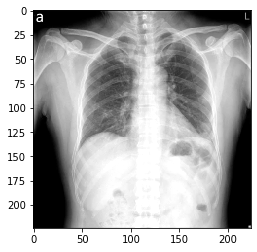

In [100]:
# A visual check for the saved files
for idx in np.random.randint(len(covid_filenames), size=2):
    image = plt.imread(str(covid_dir / os.path.basename(covid_filenames[idx])))
    plt.imshow(image)
    print(image.shape)
    plt.show()

### RSNA Image Processing

In [101]:
rsna_dir = Path('RSNA-datasets')

In [102]:
# building a metadata dataframe
# reading in csv metadata
df = pd.read_csv(str(rsna_dir / 'stage_2_train_labels.csv'), index_col='patientId')
df.drop(columns=['x', 'y', 'width', 'height'], inplace=True)
df = pd.concat((df, pd.read_csv(str(rsna_dir / 'stage_2_detailed_class_info.csv'), index_col='patientId')), axis=1)
df.head()

# getting more metadata frome dcim files
gender = []
view = []
age = []
patientId_list = []
for patientId in tqdm(df.index):
    dcm = pydicom.read_file(str(rsna_dir / 'stage_2_train_images' / patientId) + '.dcm')
    gender.append(dcm.PatientSex)
    view.append(dcm.ViewPosition)
    age.append(dcm.PatientAge)
    patientId_list.append(patientId)
    
# combining it all
frame = {
    'gender': gender,
    'view': view,
    'age': age   
}
more_meta_df = pd.DataFrame(frame, index=patientId_list)
more_meta_df.index.name = 'patientId_list'
df = pd.concat((df, more_meta_df), axis=1)
df.head()

100%|██████████████████████████████████████████████████████████████████████████████████████| 30227/30227 [02:31<00:00, 198.95it/s]


,Target,class,gender,view,age
0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,No Lung Opacity / Not Normal,F,PA,51
00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0,No Lung Opacity / Not Normal,F,PA,48
00322d4d-1c29-4943-afc9-b6754be640eb,0,No Lung Opacity / Not Normal,M,AP,19
003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,Normal,M,PA,28
00436515-870c-4b36-a041-de91049b9ab4,1,Lung Opacity,F,AP,32


In [103]:
# gathering n samples from each class
n = 259
normal = df[df['class'].isin(['Normal'])].drop_duplicates()
other = df[df['class'].isin(['No Lung Opacity / Not Normal'])].drop_duplicates()
lung_opacity = df[df['class'].isin(['Lung Opacity'])].drop_duplicates()
normal_samples = normal.sample(n=n, random_state=rng)
other_samples = other.sample(n=n, random_state=rng)
lung_opacity_samples = lung_opacity.sample(n=n, random_state=rng)

In [104]:
# saving normal samples to normal-images folder
if len(os.listdir(model_datasets_dir / 'normal-images')) == 0:
    for patientId in normal_samples.index:
        dcm = pydicom.read_file(str(rsna_dir / 'stage_2_train_images' / patientId) + '.dcm')
        image = dcm.pixel_array
        processed_image = resize_clip_and_normalize_image(image)
        processed_image = Image.fromarray((processed_image * 255).astype(np.uint8))
        processed_image.save(str(model_datasets_dir / 'normal-images' / patientId) + '.png')
else:
    raise ValueError('Directory must be empty!')

In [105]:
# saving other samples to other-images folder
if len(os.listdir(model_datasets_dir / 'other-images')) == 0:
    for patientId in other_samples.index:
        dcm = pydicom.read_file(str(rsna_dir / 'stage_2_train_images' / patientId) + '.dcm')
        image = dcm.pixel_array
        processed_image = resize_clip_and_normalize_image(image)
        processed_image = Image.fromarray((processed_image * 255).astype(np.uint8))
        processed_image.save(str(model_datasets_dir / 'other-images' / patientId) + '.png')
else:
    raise ValueError('Directory must be empty!')

In [106]:
# saving lung_opacity samples to lung_opacity-images folder
if len(os.listdir(model_datasets_dir / 'lung-opacity-images')) == 0:
    for patientId in lung_opacity_samples.index:
        dcm = pydicom.read_file(str(rsna_dir / 'stage_2_train_images' / patientId) + '.dcm')
        image = dcm.pixel_array
        processed_image = resize_clip_and_normalize_image(image)
        processed_image = Image.fromarray((processed_image * 255).astype(np.uint8))
        processed_image.save(str(model_datasets_dir / 'lung-opacity-images' / patientId) + '.png')
else:
    raise ValueError('Directory must be empty!')

In [107]:
all_samples_df = pd.concat((normal_samples, lung_opacity_samples, other_samples), axis=0)
print(all_samples_df['class'].value_counts())

Normal                          259
Lung Opacity                    259
No Lung Opacity / Not Normal    259
Name: class, dtype: int64


# Augmenting the dataset

In [127]:
import Augmentor
n_runs = 4

In [130]:
for dataset in ['covid-images', 'lung-opacity-images', 'normal-images', 'other-images']:
    pipeline = Augmentor.Pipeline(str(model_datasets_dir / dataset),
                                  output_directory='.')
    pipeline.flip_left_right(probability=0.5)
    pipeline.rotate(probability=0.5, max_left_rotation=8, max_right_rotation=8)
    pipeline.zoom(probability=0.5, min_factor=1.1, max_factor=1.25)
    for epoch in range(n_runs):  # runs through the original dataset n times 
        pipeline.process()

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x177C1FDA390>:   5%|▌          | 14/259 [00:00<00:02, 85.71 Samples/s]

Initialised with 259 image(s) found.
Output directory set to extended-model-datasets\covid-images\..

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x177C1FEE0F0>: 100%|█████████| 259/259 [00:00<00:00, 650.75 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x177BF058F98>: 100%|█████████| 259/259 [00:00<00:00, 600.93 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x177C310E320>: 100%|█████████| 259/259 [00:00<00:00, 531.83 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x177BF02F6D8>: 100%|█████████| 259/259 [00:00<00:00, 544.12 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x177BF06B048>:   3%|▎           | 7/259 [00:00<00:26,  9.35 Samples/s]

Initialised with 259 image(s) found.
Output directory set to extended-model-datasets\lung-opacity-images\..

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x177C1C6DBA8>: 100%|█████████| 259/259 [00:00<00:00, 408.52 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x177C1C95860>: 100%|█████████| 259/259 [00:00<00:00, 410.46 Samples/s]
Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x177C1FC19E8>: 100%|█| 259/259 [00:00<00:00, 422.51 Sa
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x177BF04E8D0>: 100%|█████████| 259/259 [00:00<00:00, 419.09 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x177C20F6860>:   2%|▏           | 4/259 [00:00<00:09, 26.09 Samples/s]

Initialised with 259 image(s) found.
Output directory set to extended-model-datasets\normal-images\..

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x177C2106FD0>: 100%|█████████| 259/259 [00:00<00:00, 430.95 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x177C2113CF8>: 100%|█████████| 259/259 [00:00<00:00, 459.22 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x177C20FDA20>: 100%|█████████| 259/259 [00:00<00:00, 450.44 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x177BF0399E8>: 100%|█████████| 259/259 [00:00<00:00, 455.18 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x177C1C60128>:   3%|▎           | 8/259 [00:00<00:25,  9.90 Samples/s]

Initialised with 259 image(s) found.
Output directory set to extended-model-datasets\other-images\..

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x177C1C95EF0>: 100%|█████████| 259/259 [00:00<00:00, 430.95 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x177C1C77F28>: 100%|█████████| 259/259 [00:00<00:00, 413.08 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x177C1FE7B00>: 100%|█████████| 259/259 [00:00<00:00, 442.73 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x177C1C6ACF8>: 100%|█████████| 259/259 [00:00<00:00, 433.11 Samples/s]
